In [ ]:
!unzip lung_data.zip

Archive:  lung_data.zip
   creating: lung_data/
   creating: lung_data/lung.scc/
  inflating: lung_data/lung.scc/lungscc4001.jpeg  
  inflating: lung_data/lung.scc/lungscc4002.jpeg  
  inflating: lung_data/lung.scc/lungscc4003.jpeg  
  inflating: lung_data/lung.scc/lungscc4004.jpeg  
  inflating: lung_data/lung.scc/lungscc4005.jpeg  
  inflating: lung_data/lung.scc/lungscc4006.jpeg  
  inflating: lung_data/lung.scc/lungscc4007.jpeg  
  inflating: lung_data/lung.scc/lungscc4008.jpeg  
  inflating: lung_data/lung.scc/lungscc4009.jpeg  
  inflating: lung_data/lung.scc/lungscc4010.jpeg  
  inflating: lung_data/lung.scc/lungscc4011.jpeg  
  inflating: lung_data/lung.scc/lungscc4012.jpeg  
  inflating: lung_data/lung.scc/lungscc4013.jpeg  
  inflating: lung_data/lung.scc/lungscc4014.jpeg  
  inflating: lung_data/lung.scc/lungscc4015.jpeg  
  inflating: lung_data/lung.scc/lungscc4016.jpeg  
  inflating: lung_data/lung.scc/lungscc4017.jpeg  
  inflating: lung_data/lung.scc/lungscc4018.jpeg  
 

In [ ]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Set visualization styles
sns.set_style('darkgrid')

# Define function to generate data paths and labels for lung images
def define_paths(dir):
    filepaths = []
    labels = []
    lung_classes = ['lung_aca', 'lung_n', 'lung_scc']
    for lung_class in lung_classes:
        class_path = os.path.join(dir, lung_class)
        if not os.path.exists(class_path):
            print(f"Directory {class_path} not found.")
            continue
        for file in os.listdir(class_path):
            filepaths.append(os.path.join(class_path, file))
            labels.append(lung_class)  # Simplify to use class names directly
    return filepaths, labels

# Create a DataFrame from the file paths and labels
def create_dataframe(filepaths, labels):
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Load data and split into train, validation, and test sets
def load_and_split_data(data_dir):
    filepaths, labels = define_paths(data_dir)
    df = create_dataframe(filepaths, labels)
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])
    train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df['labels'])
    return train_df, val_df, test_df

# Define image data generators
def create_generators(train_df, val_df, test_df, batch_size=32):
    img_size = (224, 224)
    train_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
    test_gen = ImageDataGenerator(rescale=1./255)
    train_generator = train_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                                    class_mode='categorical', batch_size=batch_size, shuffle=True)
    val_generator = test_gen.flow_from_dataframe(val_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                                 class_mode='categorical', batch_size=batch_size)
    test_generator = test_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                                  class_mode='categorical', batch_size=batch_size, shuffle=False)
    return train_generator, val_generator, test_generator

# Build and compile the model
def build_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(3, activation='softmax')  # Assumes three classes
    ])
    model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:

# Main script
data_dir = input('Enter the directory of your lung data: ')
train_df, val_df, test_df = load_and_split_data(data_dir)

# Prepare generators
train_gen, val_gen, test_gen = create_generators(train_df, val_df, test_df)

# Build and train the model
model = build_model((224, 224, 3))
history = model.fit(train_gen, epochs=10, validation_data=val_gen)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc*100:.2f}%")


Enter the directory of your lung data: /content/lung_data
Found 90 validated image filenames belonging to 3 classes.
Found 30 validated image filenames belonging to 3 classes.
Found 30 validated image filenames belonging to 3 classes.
Epoch 1/10
3/3 [==============================] - 9s 3s/step - loss: 5.6469 - accuracy: 0.3000 - val_loss: 2.4168 - val_accuracy: 0.3333
Epoch 2/10
3/3 [==============================] - 8s 3s/step - loss: 2.3737 - accuracy: 0.3000 - val_loss: 1.2857 - val_accuracy: 0.6333
Epoch 3/10
3/3 [==============================] - 8s 3s/step - loss: 1.0147 - accuracy: 0.6111 - val_loss: 0.6363 - val_accuracy: 0.6333
Epoch 4/10
3/3 [==============================] - 8s 2s/step - loss: 0.6265 - accuracy: 0.6333 - val_loss: 0.5499 - val_accuracy: 0.6333
Epoch 5/10
3/3 [==============================] - 8s 2s/step - loss: 0.5245 - accuracy: 0.6889 - val_loss: 0.6179 - val_accuracy: 0.6333
Epoch 6/10
3/3 [==============================] - 9s 3s/step - loss: 0.4967 - ac

In [ ]:

# Generate predictions and display classification report
predictions = model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


1/1 [==============================] - 1s 894ms/step
              precision    recall  f1-score   support

    lung_aca       0.60      0.30      0.40        10
      lung_n       0.90      0.90      0.90        10
    lung_scc       0.60      0.90      0.72        10

    accuracy                           0.70        30
   macro avg       0.70      0.70      0.67        30
weighted avg       0.70      0.70      0.67        30



Enter the path to the image you want to classify: /content/demonil.jpg
1/1 [==============================] - 0s 41ms/step
Predicted Class: lung_aca


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


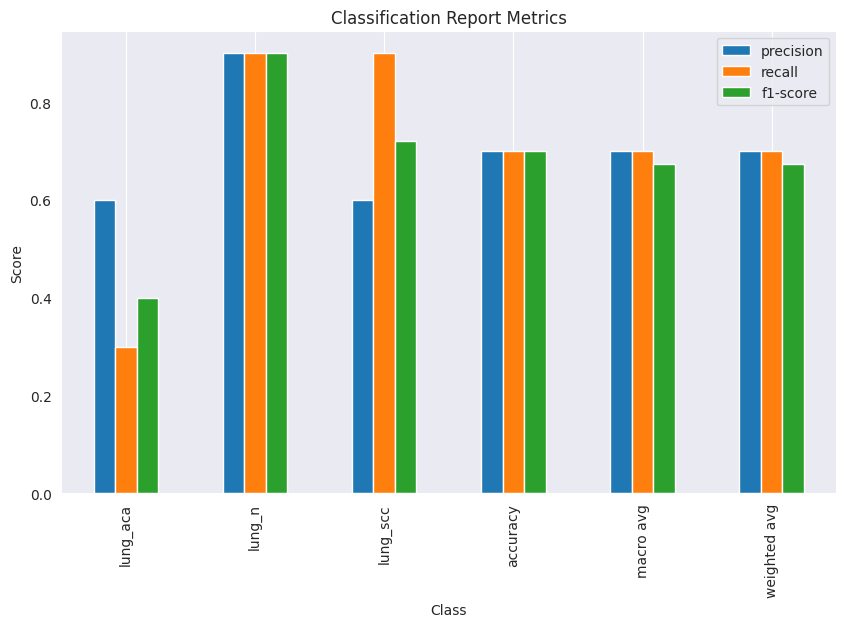

In [ ]:

# Ask for an image input for prediction
image_path = input("Enter the path to the image you want to classify: ")

# Load and preprocess the input image
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
img_array /= 255.0  # Rescale pixel values

# Make predictions
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
class_labels = list(test_gen.class_indices.keys())
predicted_class = class_labels[predicted_class_index]

# Display the prediction result
print("Predicted Class:", predicted_class)

# Save the model if needed
model.save('lung_cancer_detection_model.h5')

# Plotting classification report metrics
report_data = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
df = pd.DataFrame(report_data).transpose()
df = df.drop(['support'], axis=1)  # Drop the 'support' column
df.plot(kind='bar', figsize=(10,6))
plt.title('Classification Report Metrics')
plt.xlabel('Class')
plt.ylabel('Score')
plt.grid(axis='y')
plt.show()  # Add this line to prevent scrolling

In [ ]:
# Generate performance metrics
predictions = model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Calculate accuracy and validation results
accuracy = np.sum(predicted_classes == true_classes) / len(true_classes)
validation_results = model.evaluate(test_gen)

# Display results
print("Performance Metrics:")
print(report)

print("\nConfusion Matrix:")
print(conf_matrix)

print("\nAccuracy:")
print(f"Accuracy: {accuracy*100:.2f}%")

print("\nValidation Results:")
print(f"Test Loss: {validation_results[0]}")
print(f"Test Accuracy: {validation_results[1]*100:.2f}%")


1/1 [==============================] - 2s 2s/step - loss: 0.6130 - accuracy: 0.7000
Performance Metrics:
              precision    recall  f1-score   support

    lung_aca       0.60      0.30      0.40        10
      lung_n       0.90      0.90      0.90        10
    lung_scc       0.60      0.90      0.72        10

    accuracy                           0.70        30
   macro avg       0.70      0.70      0.67        30
weighted avg       0.70      0.70      0.67        30


Confusion Matrix:
[[3 1 6]
 [1 9 0]
 [1 0 9]]

Accuracy:
Accuracy: 70.00%

Validation Results:
Test Loss: 0.61298006772995
Test Accuracy: 70.00%
